In [1]:
# Import packages and set configuration
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
# Load tickers
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]

In [3]:
ps_start = "2024-01-01"
ps_end = "2024-07-01"

# training_start = "2024-07-01"
# training_end = "2024-09-01"

trading_start = "2024-07-01"
trading_end = "2024-09-01"

interval = "1h"

In [4]:
# Load data
from modules.data_services.data_loaders import load_data

df = load_data(
    tickers=tickers,
    start=ps_start,
    end=ps_end,
    interval=interval
)

In [5]:
# Pair Selection
from modules.pair_selection.statistical_tests import engle_granger_cointegration

eg_df = engle_granger_cointegration(df)
display(eg_df.head(5))
tickers = eg_df.iloc[0:1, 0].tolist()
ticker_x = tickers[0].split('-')[0]
ticker_y = tickers[0].split('-')[1]

,pair,eg_p_value,adf_stat
0,XRPUSDT-DOTUSDT,0.003562,-4.206823
1,DOGEUSDT-LTCUSDT,0.003589,-4.204631
2,SHIBUSDT-LTCUSDT,0.019010,-3.687586
3,DOGEUSDT-BCHUSDT,0.022057,-3.636638
4,SOLUSDT-DOGEUSDT,0.041727,-3.405652


In [6]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

In [7]:
# # Perform Bayesian Optimization
# from modules.performance.strategy import calc_bayesian_params
#
# metric = ("total_return", "0.05% fee")
# best_params, best_score = calc_bayesian_params(ticker_x, ticker_y, fee_rate, initial_cash, position_size, training_start, training_end, interval, is_spread, static_hedge, metric)
# print(best_params)
# print(best_score)

{'rolling_window': np.int64(82), 'entry_threshold': 2.1002791110470103, 'exit_threshold': 0.29436698685538426, 'stop_loss': 2.2853199897712013}
0.3165

In [8]:
entry_threshold = 2.1002791110470103
exit_threshold = 0.29436698685538426
stop_loss = 2.2853199897712013
rolling_window = 82

# entry_threshold = best_params["entry_threshold"]
# exit_threshold = best_params["exit_threshold"]
# stop_loss = best_params["stop_loss"]
# rolling_window = best_params["rolling_window"]

In [9]:
# entry_threshold = 2
# exit_threshold = 0
# stop_loss = 2
# rolling_window = 60

In [10]:
# Load pair and calculate returns
from modules.data_services.data_loaders import load_pair
from modules.data_services.data_utils import pre_training_start, add_returns

pt_start = pre_training_start(start=trading_start, interval=interval, rolling_window_steps=rolling_window)

pair = load_pair(x=ticker_x, y=ticker_y, start=pt_start, end=trading_end, interval=interval)
add_returns(pair)

In [11]:
# Run strategy
from modules.performance.strategy import run_strategy

is_spread = False
static_hedge = False

pair.fee_rate = fee_rate
pair.initial_cash = initial_cash

run_strategy(pair, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size, is_spread=is_spread, static_hedge=static_hedge)
pair.data.drop(columns=['total_return', 'total_fees', 'net_return'])

,XRPUSDT,DOTUSDT,z_score,beta,entry_thr,exit_thr,sl_thr,w_x,w_y,q_x,q_y,position,total_return_pct,net_return_pct
open_time,,,,,,,,,,,,,,
2024-06-29 10:00:00,0.4765,6.138,-0.1982,0.1798,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.0000,0.0000
2024-06-29 11:00:00,0.4766,6.135,-0.1643,0.1751,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.0000,0.0000
2024-06-29 12:00:00,0.4752,6.133,-0.1768,0.1742,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.0000,0.0000
2024-06-29 13:00:00,0.4752,6.124,-0.1169,0.1735,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.0000,0.0000
2024-06-29 14:00:00,0.4750,6.097,0.0266,0.1730,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31 20:00:00,0.5674,4.235,1.1342,0.5392,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.3284,0.3165
2024-08-31 21:00:00,0.5662,4.260,0.3966,0.5285,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.3284,0.3165
2024-08-31 22:00:00,0.5674,4.251,0.6888,0.5277,2.1003,0.2944,None,None,None,0.0,0.0,0.0,0.3284,0.3165


In [12]:
# Calculate statistics
from modules.performance.strategy import calculate_stats

pair.stats = calculate_stats(pair)
pair.stats

,0% fee,0.05% fee
metric,,
total_return,0.3284,0.3165
cagr,4.0988,3.8435
volatility,0.0049,0.0049
volatility_annual,0.4592,0.4618
max_drawdown,-0.1279,-0.1298
win_count,9.0000,9.0000
lose_count,3.0000,3.0000
win_rate,0.7500,0.7500
max_win,0.1638,0.1633


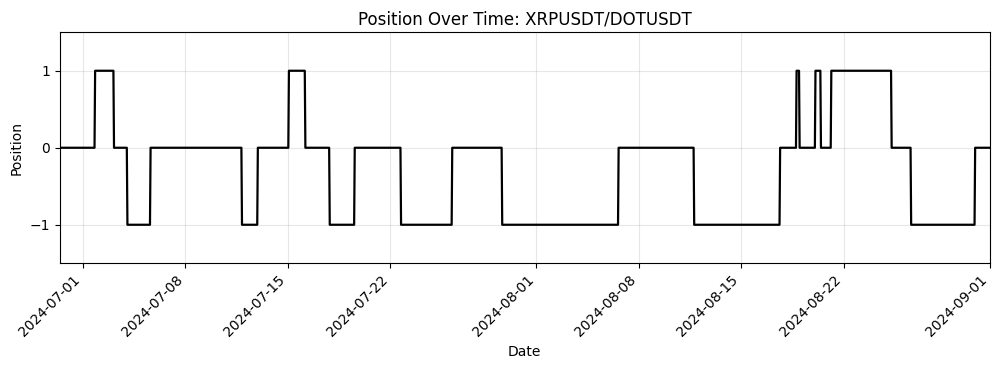

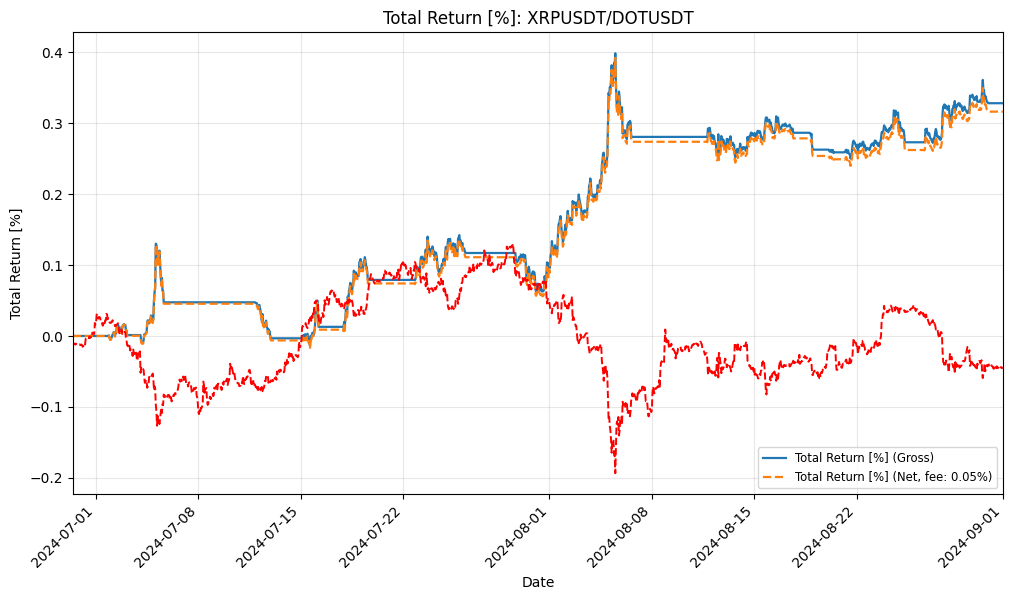

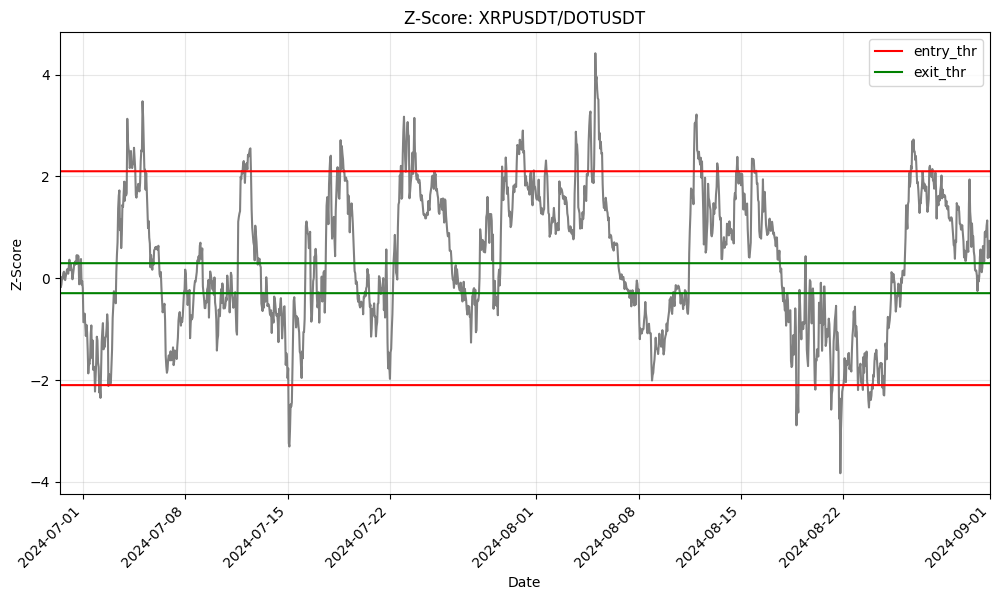

In [13]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(pair, 'strategy', False, True)
plot_pnl(pair, 'strategy', False, True, btc=True)
plot_zscore(pair)